In [1]:
import tensorflow as tf

# gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/cyp/ml/dataset/dogs-vs-cats/data_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels


train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

2022-05-17 14:03:05.623839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 14:03:05.629499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 14:03:05.629924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 14:03:05.646730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

1 Physical GPUs, 1 Logical GPUs
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  

2022-05-17 14:03:06.918489: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-05-17 14:03:07.289064: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-17 14:03:07.691210: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1004.77MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-05-17 14:03:07.772215: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 828.81MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-05-17 14:03:07.936644: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying 

1/1 [==============================] - 0s 15ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 16ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


In [2]:
print('train_features shape: ', train_features.shape)
print('train_labels shape: ', train_labels.shape)
print('validation_features shape: ', validation_features.shape)
print('validation_labels shape: ', validation_labels.shape)
print('test_features shape: ', test_features.shape)
print('test_labels shape: ', test_labels.shape)

train_features shape:  (2000, 4, 4, 512)
train_labels shape:  (2000,)
validation_features shape:  (1000, 4, 4, 512)
validation_labels shape:  (1000,)
test_features shape:  (1000, 4, 4, 512)
test_labels shape:  (1000,)


In [4]:
# 将形状 (samples, 4, 4, 512) 展平为形状 (samples, 8192)
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

# 定义并训练密集连接分类器
from keras import models
from keras import layers
from keras import  optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 9ms/step - loss: 0.6044 - acc: 0.6630 - val_loss: 0.4321 - val_acc: 0.8390
Epoch 2/30
100/100 [==============================] - 1s 8ms/step - loss: 0.4222 - acc: 0.8120 - val_loss: 0.3676 - val_acc: 0.8550
Epoch 3/30
100/100 [==============================] - 1s 8ms/step - loss: 0.3536 - acc: 0.8510 - val_loss: 0.3222 - val_acc: 0.8730
Epoch 4/30
100/100 [==============================] - 1s 8ms/step - loss: 0.3052 - acc: 0.8755 - val_loss: 0.3040 - val_acc: 0.8830
Epoch 5/30
100/100 [==============================] - 1s 8ms/step - loss: 0.2938 - acc: 0.8715 - val_loss: 0.2837 - val_acc: 0.8900
Epoch 6/30
100/100 [==============================] - 1s 8ms/step - loss: 0.2598 - acc: 0.8980 - val_loss: 0.2703 - val_acc: 0.8930
Epoch 7/30
100/100 [==============================] - 1s 8ms/step - loss: 0.2436 - acc: 0.9030 - val_loss: 0.2646 - val_acc: 0.8980
Epoch 8/30
100/100 [==============================] - 1s 8ms/step - loss: 0.

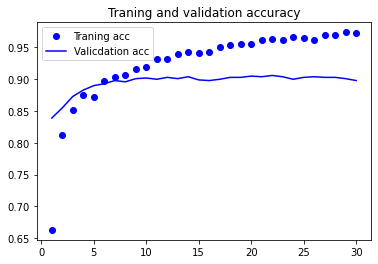

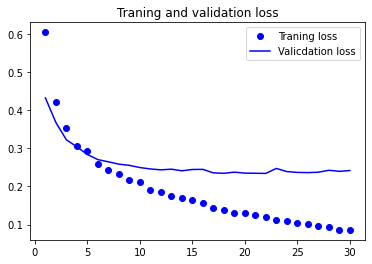

In [6]:
# 绘制结果
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Traning acc')
plt.plot(epochs, val_acc, 'b', label='Valicdation acc')
plt.title('Traning and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Traning loss')
plt.plot(epochs, val_loss, 'b', label='Valicdation loss')
plt.title('Traning and validation loss')
plt.legend()

plt.show()

### 使用数据增强进行特征提取

在卷积积上添加一个密集连接分类器

In [7]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [9]:
print('This is the number of trainable weights before freezing conv base: ', len(model.trainable_weights))

conv_base.trainable=False

print('This is the number of trainable weights after freezing conv base: ', len(model.trainable_weights))

This is the number of trainable weights before freezing conv base:  30
This is the number of trainable weights after freezing conv base:  4


In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255) # 注意不能增强验证数据

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])


history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30


/tmp/ipykernel_26460/1661218884.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - 54s 540ms/step - loss: 0.4037 - acc: 0.8250 - val_loss: 0.3118 - val_acc: 0.8800
Epoch 2/30
100/100 [==============================] - 54s 539ms/step - loss: 0.3805 - acc: 0.8330 - val_loss: 0.3033 - val_acc: 0.8680
Epoch 3/30
100/100 [==============================] - 54s 539ms/step - loss: 0.3715 - acc: 0.8450 - val_loss: 0.2828 - val_acc: 0.8850
Epoch 4/30
100/100 [==============================] - 54s 539ms/step - loss: 0.3562 - acc: 0.8455 - val_loss: 0.2766 - val_acc: 0.8870
Epoch 5/30
100/100 [==============================] - 54s 539ms/step - loss: 0.3568 - acc: 0.8345 - val_loss: 0.2783 - val_acc: 0.8910
Epoch 6/30
100/100 [==============================] - 54s 540ms/step - loss: 0.3468 - acc: 0.8435 - val_loss: 0.2669 - val_acc: 0.8920
Epoch 7/30
100/100 [==============================] - 54s 539ms/step - loss: 0.3439 - acc: 0.8400 - val_loss: 0.2676 - val_acc: 0.8930
Epoch 8/30
100/100 [==============================] - 54s 539ms/st

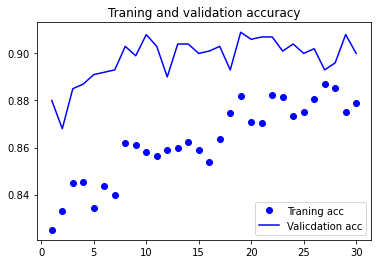

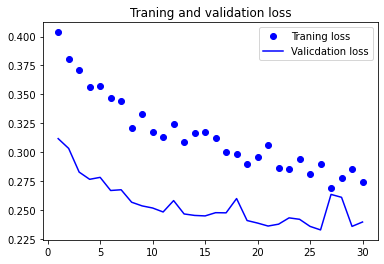

In [14]:
# 绘制结果
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Traning acc')
plt.plot(epochs, val_acc, 'b', label='Valicdation acc')
plt.title('Traning and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Traning loss')
plt.plot(epochs, val_loss, 'b', label='Valicdation loss')
plt.title('Traning and validation loss')
plt.legend()

plt.show()

## 微调模型

In [15]:
# 冻结直到某一层的所有层
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])


history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30


/tmp/ipykernel_26460/2983776642.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


  1/100 [..............................] - ETA: 2:24 - loss: 0.1865 - acc: 0.9000

2022-05-17 16:05:00.728654: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


100/100 [==============================] - 63s 622ms/step - loss: 0.2887 - acc: 0.8690 - val_loss: 0.2234 - val_acc: 0.9050
Epoch 2/30
100/100 [==============================] - 62s 621ms/step - loss: 0.2626 - acc: 0.8885 - val_loss: 0.2086 - val_acc: 0.9150
Epoch 3/30
100/100 [==============================] - 62s 621ms/step - loss: 0.2402 - acc: 0.9020 - val_loss: 0.2234 - val_acc: 0.9080
Epoch 4/30
100/100 [==============================] - 62s 622ms/step - loss: 0.2220 - acc: 0.9035 - val_loss: 0.2023 - val_acc: 0.9210
Epoch 5/30
100/100 [==============================] - 62s 622ms/step - loss: 0.1943 - acc: 0.9175 - val_loss: 0.1971 - val_acc: 0.9230
Epoch 6/30
100/100 [==============================] - 62s 622ms/step - loss: 0.1949 - acc: 0.9215 - val_loss: 0.1991 - val_acc: 0.9260
Epoch 7/30
100/100 [==============================] - 62s 622ms/step - loss: 0.1764 - acc: 0.9310 - val_loss: 0.1896 - val_acc: 0.9350
Epoch 8/30
100/100 [==============================] - 62s 622ms/st

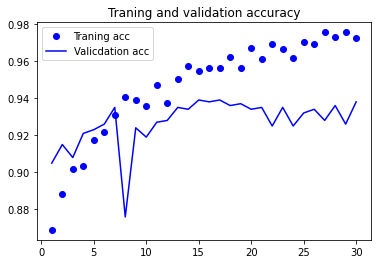

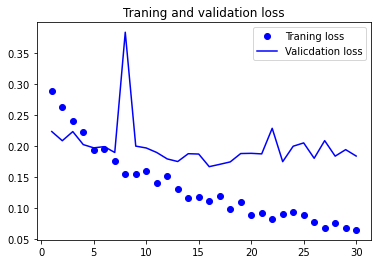

In [16]:
# 绘制结果
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Traning acc')
plt.plot(epochs, val_acc, 'b', label='Valicdation acc')
plt.title('Traning and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Traning loss')
plt.plot(epochs, val_loss, 'b', label='Valicdation loss')
plt.title('Traning and validation loss')
plt.legend()

plt.show()

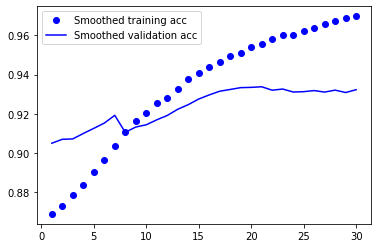

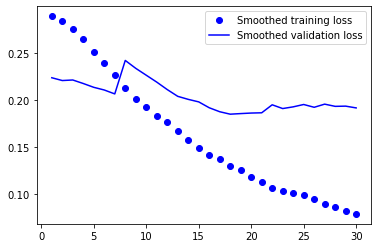

In [17]:
# 使曲线变得平滑
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.legend()

plt.show()

In [25]:
# 测试模型
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size = 20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc: ', test_acc)

Found 1000 images belonging to 2 classes.


/tmp/ipykernel_26460/2452504896.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)


test acc:  0.9449999928474426
